# 中间件

[中间件](https://docs.langchain.com/oss/python/langchain/middleware/overview)（middleware）是本次更新中最亮眼的特性，诸多新功能都是藉由中间件实现的，比如动态系统提示词、人机交互、动态注入上下文等等。

本节我们将使用中间件实现四个功能：

- 预算控制
- 消息截断
- 敏感词过滤
- 用户敏感信息过滤

## 一、预算控制

随着对话轮次增加，积累的历史对话越来越多，每次请求的费用也随之增加。为了控制预算，我们可以设定在对话超过某个轮次之后，切换到低费率模型。该功能可以通过中间件实现。

In [2]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain.agents.middleware import wrap_model_call, ModelRequest, ModelResponse
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState

# 加载模型配置
_ = load_dotenv()

# 低费率模型
basic_model = ChatOpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
    model="Qwen/Qwen3-8B",
)

# 高费率模型
advanced_model = ChatOpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
    model="Qwen/Qwen3-32B",
)

具体来说，下面的预算控制功能是通过一个叫 [`@wrap_model_call`](https://reference.langchain.com/python/langchain/middleware/#langchain.agents.middleware.wrap_model_call) 的装饰器，所装饰的中间件实现的。

[接口文档](https://reference.langchain.com/python/langchain/middleware/) 中可以找到所有装饰器：

- `@before_agent`: 封装在 Agent 执行之前执行的逻辑
- `@before_model`: 封装在模型调用之前执行的逻辑
- `@after_agent`: 封装在 Agent 执行之后执行的逻辑
- `@after_model`: 封装在模型调用之后执行的逻辑
- `@wrap_model_call`: 控制模型调用过程
- `@wrap_tool_call`: 控制工具调用过程
- `@dynamic_prompt`: 动态修改系统提示词
- `@hook_config`: 配置钩子行为

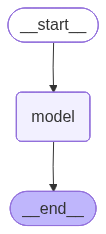

In [6]:
@wrap_model_call
def dynamic_model_selection(request: ModelRequest, handler) -> ModelResponse:
    """Choose model based on conversation complexity."""
    message_count = len(request.state["messages"])

    if message_count > 3:
        # Use an advanced model for longer conversations
        model = advanced_model
    else:
        model = basic_model

    request.model = model
    print(f"message_count: {message_count}")
    print(f"model_name: {model.model_name}")

    return handler(request)

agent = create_agent(
    model=basic_model,  # Default model
    middleware=[dynamic_model_selection]
)

agent

In [7]:
state: MessagesState = {"messages": []}
items = ['汽车', '飞机', '摩托车', '自行车']
for idx, i in enumerate(items):
    print(f"\n=== Round {idx+1} ===")
    state["messages"] += [HumanMessage(content=f"{i}有几个轮子，请简单回答")]
    result = agent.invoke(state)
    state["messages"] = result["messages"]
    print(f"content: {result["messages"][-1].content}")


=== Round 1 ===
message_count: 1
model_name: Qwen/Qwen3-8B


/var/folders/dt/8fxvkyrx5cx5k_2l94yt12640000gn/T/ipykernel_3087/587980093.py:12: DeprecationWarning: Direct attribute assignment to ModelRequest.model is deprecated. Use request.override(model=...) instead to create a new request with the modified attribute.
  request.model = model


content: 汽车通常有四个轮子。

=== Round 2 ===
message_count: 3
model_name: Qwen/Qwen3-8B


/var/folders/dt/8fxvkyrx5cx5k_2l94yt12640000gn/T/ipykernel_3087/587980093.py:12: DeprecationWarning: Direct attribute assignment to ModelRequest.model is deprecated. Use request.override(model=...) instead to create a new request with the modified attribute.
  request.model = model


content: 飞机通常有多个轮子，具体数量因飞机类型而异。大多数商用客机有**8个轮子**（4个主轮和2个前轮），但也有例外，如一些小型飞机可能只有**2到4个轮子**。

=== Round 3 ===
message_count: 5
model_name: Qwen/Qwen3-32B


/var/folders/dt/8fxvkyrx5cx5k_2l94yt12640000gn/T/ipykernel_3087/587980093.py:12: DeprecationWarning: Direct attribute assignment to ModelRequest.model is deprecated. Use request.override(model=...) instead to create a new request with the modified attribute.
  request.model = model


content: 摩托车通常有**两个轮子**。

=== Round 4 ===
message_count: 7
model_name: Qwen/Qwen3-32B


/var/folders/dt/8fxvkyrx5cx5k_2l94yt12640000gn/T/ipykernel_3087/587980093.py:12: DeprecationWarning: Direct attribute assignment to ModelRequest.model is deprecated. Use request.override(model=...) instead to create a new request with the modified attribute.
  request.model = model


content: 

自行车通常有**2个轮子**。


## 二、消息截断

智能体系统上下文长度是有限。若超过限制，就应该想办法压缩上下文。在所有方法中，最简单粗暴的就是截断。截断功能可以利用 `@before_model` 装饰器实现。

In [9]:
from langchain.messages import RemoveMessage
from langgraph.graph.message import REMOVE_ALL_MESSAGES
from langgraph.checkpoint.memory import InMemorySaver
from langchain.agents import create_agent, AgentState
from langchain.agents.middleware import before_model
from langgraph.runtime import Runtime
from langchain_core.runnables import RunnableConfig
from typing import Any

在下面的例子中，由于我们在第一条消息中告诉智能体我叫 bob，并且让智能体始终保留第一条消息，因此智能体总是记得我是 bob.

In [10]:
@before_model
def trim_messages(state: AgentState, runtime: Runtime) -> dict[str, Any] | None:
    """Keep only the last few messages to fit context window."""
    messages = state["messages"]

    if len(messages) <= 3:
        return None  # No changes needed

    first_msg = messages[0]
    recent_messages = messages[-3:] if len(messages) % 2 == 0 else messages[-4:]
    new_messages = [first_msg] + recent_messages

    return {
        "messages": [
            RemoveMessage(id=REMOVE_ALL_MESSAGES),
            *new_messages
        ]
    }

agent = create_agent(
    basic_model,
    middleware=[trim_messages],
    checkpointer=InMemorySaver(),
)

config: RunnableConfig = {"configurable": {"thread_id": "1"}}

def agent_invoke(agent):
    agent.invoke({"messages": "hi, my name is bob"}, config)
    agent.invoke({"messages": "write a short poem about cats"}, config)
    agent.invoke({"messages": "now do the same but for dogs"}, config)
    final_response = agent.invoke({"messages": "what's my name?"}, config)
    
    final_response["messages"][-1].pretty_print()

agent_invoke(agent)

================================== Ai Message ==================================

Your name is Bob! 😊  
Let me know if you'd like a poem about Bob or anything else—maybe even a poem about Bob the dog?


接下来，对中间件做一些更改。改为保留最后两条对话记录，现在智能体不记得我是 bob 了。

In [11]:
@before_model
def trim_without_first_message(state: AgentState, runtime: Runtime) -> dict[str, Any] | None:
    """Keep only the last few messages to fit context window."""
    messages = state["messages"]

    return {
        "messages": [
            RemoveMessage(id=REMOVE_ALL_MESSAGES),
            *messages[-2:]
        ]
    }

agent = create_agent(
    basic_model,
    middleware=[trim_without_first_message],
    checkpointer=InMemorySaver(),
)

agent_invoke(agent)

================================== Ai Message ==================================

I don't know your name yet, but I'm here to learn it! What's your name? 😊


## 三、护栏：敏感词过滤

护栏（Guardrails）是智能体提供的一类内容安全能力的统称。我们知道模型本身是有内容安全能力的，但很容易被绕过，这一般被称为破甲或者破限。智能体可以在模型之外提供额外的安全能力。这是通过工程上的强制性检查实现的。

在 LangGraph 中，护栏可以通过中间件实现。下面我们实现一个简单的“护栏”：若用户最新一条输入中包含指定的敏感词，则智能体拒绝回答用户的问题。

In [12]:
from typing import Any

from langchain.agents.middleware import before_agent, AgentState
from langgraph.runtime import Runtime

banned_keywords = ["hack", "exploit", "malware"]

@before_agent(can_jump_to=["end"])
def content_filter(state: AgentState, runtime: Runtime) -> dict[str, Any] | None:
    """Deterministic guardrail: Block requests containing banned keywords."""
    # Get the first user message
    if not state["messages"]:
        return None

    last_message = state["messages"][-1]
    if last_message.type != "human":
        return None

    content = last_message.content.lower()

    # Check for banned keywords
    for keyword in banned_keywords:
        if keyword in content:
            # Block execution before any processing
            return {
                "messages": [{
                    "role": "assistant",
                    "content": "I cannot process requests containing inappropriate content. Please rephrase your request."
                }],
                "jump_to": "end"
            }

    return None

agent = create_agent(
    model=basic_model,
    middleware=[content_filter],
)

# This request will be blocked before any processing
result = agent.invoke({
    "messages": [{"role": "user", "content": "How do I hack into a database?"}]
})

In [13]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

How do I hack into a database?
================================== Ai Message ==================================

I cannot process requests containing inappropriate content. Please rephrase your request.


## 四、护栏：PII 检测

接下来，我们继续编写护栏。[PII](https://docs.langchain.com/oss/python/langchain/guardrails#pii-detection)（Personally Identifiable Information）检测是一个过滤用户敏感信息的护栏功能。在下面的例子中，我们将检测用户的邮箱、IP、地址、银行卡等敏感信息。

我们将尝试两种策略处理检测到的敏感信息：
1. 拒绝回答用户的问题
2. 将敏感信息替换为一连串的星号 `********`

In [14]:
from textwrap import dedent
from pydantic import BaseModel, Field

# 可信任的模型，一般是本地模型，为了方便，这里依然使用qwen
trusted_model = ChatOpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
    model="Qwen/Qwen3-8B",
)

# 用于格式化智能体输出，若发现敏感信息返回True，没发现返回False
class PiiCheck(BaseModel):
    """Structured output indicating whether text contains PII."""
    is_pii: bool = Field(description="Whether the text contains PII")

def message_with_pii(pii_middleware):
    agent = create_agent(
        model=basic_model,
        middleware=[pii_middleware],
    )

    # This request will be blocked before any processing
    result = agent.invoke({
        "messages": [{
            "role": "user",
            "content": dedent(
                """
                File "/home/luochang/proj/agent.py", line 53, in my_agent
                    agent = create_react_agent(
                            ^^^^^^^^^^^^^^^^^^^
                File "/home/luochang/miniconda3/lib/python3.12/site-packages/typing_extensions.py", line 2950, in wrapper
                    return arg(*args, **kwargs)
                        ^^^^^^^^^^^^^^^^^^^^
                File "/home/luochang/miniconda3/lib/python3.12/site-packages/langgraph/prebuilt/chat_agent_executor.py", line 566, in create_react_agent
                    model = cast(BaseChatModel, model).bind_tools(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                AttributeError: 'RunnableLambda' object has no attribute 'bind_tools'
    
                ---
    
                为啥报错
                """).strip()
        }]
    })

    return result

**策略一**：如遇敏感信息，拒绝回复。

In [15]:
@before_agent(can_jump_to=["end"])
def content_blocker(state: AgentState,  runtime: Runtime) -> dict[str, Any] | None:
    """Deterministic guardrail: Block requests containing banned keywords."""
    # Get the first user message
    if not state["messages"]:
        return None

    last_message = state["messages"][-1]
    if last_message.type != "human":
        return None

    content = last_message.content.lower()
    prompt = (
        "你是一个隐私保护助手。请识别下面文本中涉及个人可识别信息（PII），"
        "例如：姓名、身份证号、护照号、电话号码、邮箱、住址、银行卡号、社交账号、车牌等。"
        "特别注意，若代码、文件路径中包含用户名，也应被视为敏感信息。"
        "若包含敏感信息，请返回{\"is_pii\": True}，否则返回{\"is_pii\": False}。"
        "请严格以 json 格式返回，并且只输出 json。文本如下：\n\n" + content
    )

    pii_agent = trusted_model.with_structured_output(PiiCheck)
    result = pii_agent.invoke(prompt)

    if result.is_pii is True:
        # Block execution before any processing
        return {
            "messages": [{
                "role": "assistant",
                "content": "I cannot process requests containing inappropriate content. Please rephrase your request."
            }],
            "jump_to": "end"
        }
    else:
        print("No PII found")

    return None

In [16]:
result = message_with_pii(pii_middleware=content_blocker)

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

File "/home/luochang/proj/agent.py", line 53, in my_agent
    agent = create_react_agent(
            ^^^^^^^^^^^^^^^^^^^
File "/home/luochang/miniconda3/lib/python3.12/site-packages/typing_extensions.py", line 2950, in wrapper
    return arg(*args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^
File "/home/luochang/miniconda3/lib/python3.12/site-packages/langgraph/prebuilt/chat_agent_executor.py", line 566, in create_react_agent
    model = cast(BaseChatModel, model).bind_tools(
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'RunnableLambda' object has no attribute 'bind_tools'

---

为啥报错
================================== Ai Message ==================================

I cannot process requests containing inappropriate content. Please rephrase your request.


**策略二**：如遇敏感信息，使用 `*` 号屏蔽敏感信息。

In [17]:
@before_agent(can_jump_to=["end"])
def content_filter(state: AgentState,  runtime: Runtime) -> dict[str, Any] | None:
    """Deterministic guardrail: Block requests containing banned keywords."""
    # Get the first user message
    if not state["messages"]:
        return None

    last_message = state["messages"][-1]
    if last_message.type != "human":
        return None

    content = last_message.content.lower()
    prompt = (
        "你是一个隐私保护助手。请识别下面文本中涉及个人可识别信息（PII），"
        "例如：姓名、身份证号、护照号、电话号码、邮箱、住址、银行卡号、社交账号、车牌等。"
        "特别注意，若代码、文件路径中包含用户名，也应被视为敏感信息。"
        "若包含敏感信息，请返回{\"is_pii\": True}，否则返回{\"is_pii\": False}。"
        "请严格以 json 格式返回，并且只输出 json。文本如下：\n\n" + content
    )

    pii_agent = trusted_model.with_structured_output(PiiCheck)
    result = pii_agent.invoke(prompt)

    if result.is_pii is True:
        mask_prompt = (
            "你是一个隐私保护助手。请将下面文本中的所有个人可识别信息（PII）用星号（*）替换。"
            "仅替换敏感片段，其他文本保持不变。"
            "只输出处理后的文本，不要任何解释或额外内容。文本如下：\n\n" + last_message.content
        )
        masked_message = basic_model.invoke(mask_prompt)
        return {
            "messages": [{
                "role": "assistant",
                "content": masked_message.content
            }]
        }
    else:
        print("No PII found")

    return None

In [18]:
result = message_with_pii(pii_middleware=content_filter)

for message in result["messages"]:
    message.pretty_print()

No PII found
================================ Human Message =================================

File "/home/luochang/proj/agent.py", line 53, in my_agent
    agent = create_react_agent(
            ^^^^^^^^^^^^^^^^^^^
File "/home/luochang/miniconda3/lib/python3.12/site-packages/typing_extensions.py", line 2950, in wrapper
    return arg(*args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^
File "/home/luochang/miniconda3/lib/python3.12/site-packages/langgraph/prebuilt/chat_agent_executor.py", line 566, in create_react_agent
    model = cast(BaseChatModel, model).bind_tools(
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'RunnableLambda' object has no attribute 'bind_tools'

---

为啥报错
================================== Ai Message ==================================

你遇到的这个错误信息是：

```
AttributeError: 'RunnableLambda' object has no attribute 'bind_tools'
```

从错误信息来看，你的代码中调用了 `create_react_agent` 函数，但传入的模型对象是一个 `RunnableLambda` 类型，而不是支持 `bind_tools` 方法的那个模型类型。

---

### ✅ 错误原因解释：